# Destiny 2 Weapon Prediction
Predict the weapon archetype of a Destiny 2 weapon given its stats and other features

## Step 1 - Import the necessary packages

In [27]:
# Import file/data management
import json
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier)
from sklearn.tree import DecisionTreeClassifier

# For tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, make_scorer, confusion_matrix, plot_confusion_matrix

# Hide some warnings
import warnings
warnings.filterwarnings('ignore')

/home/therealcooper/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/therealcooper/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/therealcooper/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/therealcooper/.local/lib/python3.8/site-packages/skl

## Step 2 - Clean up the data

In [2]:
# Read database
with open('data/weapons/all.json', 'r') as json_file:
    js = json.load(json_file)
df = pd.json_normalize(js)

# 1) Remove sunset gear
# (Assumes weapon type rules were adhered to better after sunsetting)
df = df[df['powercap'].isna()]

# 2) Keep only legendary gear
# (Exotics are unique and under legendary likely has worse stats in general)
# (Possibly worth experimenting as an alternate prediction though!)
df = df[df['weapon_tier'] == 'legendary']

# 3) Convert categorical columns into numerics
ammo_dummies = pd.get_dummies(df['ammo_type'])
ammo_cols = list(ammo_dummies.columns)
element_dummies = pd.get_dummies(df['element_class'])
element_cols = list(element_dummies.columns)
df = pd.concat([df, ammo_dummies, element_dummies], axis=1)

# 4) Remove unecessary columns (keeps perks and frame.name for future models)
df = df.drop(columns=['id', 'name', 'icon', 'watermark', 'screenshot',
                      'flavor_text', 'weapon_tier', 'powercap', 'frame.description', 
                      'frame.icon', 'ammo_type', 'element_class'])

# 5) Replace NaN values with -1 to separate from real values
df.fillna(-1, inplace=True)

## Step 3 - Define the models and build the dataset

In [3]:
def split_dataset(dataset, target_col, test_size=0.2):
    '''
    Make dataset, build test using test_ratio
    '''
    # Organize data
    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]

    # Create train/test datasets
    return train_test_split(X, y, test_size=test_size, stratify=y)

# Dataset with no perks or frame
std_df = df.drop(columns=['frame.name', 'perks'])
X_train, X_test, y_train, y_test = split_dataset(std_df, 'weapon_type')


# Models
models = [('decision_tree', DecisionTreeClassifier(random_state=1)),
          ('log_regression', LogisticRegression(random_state=1)),
          ('bagging', BaggingClassifier(random_state=1)),
          ('random_forest', RandomForestClassifier(random_state=1)),
          ('gbm', GradientBoostingClassifier(random_state=1)),
          ('adaboost', AdaBoostClassifier(random_state=1))]


## Step 4 - Validate the models

In [56]:
def model_performance_classification(model, name, X_test, target):
    '''
    Test classification scores for a given model
    '''

    # Run a prediction
    predictions = model.predict(X_test)

    # Calculate performance metrics
    accuracy  = accuracy_score(target, predictions)
    recall    = recall_score(target, predictions, average='macro')
    precision = precision_score(target, predictions, average='macro')
    f1        = f1_score(target, predictions, average='macro')

    return pd.DataFrame({
            'Name'      : [name],
            'Accuracy'  : [accuracy],
            'Recall'    : [recall],
            'Precision' : [precision],
            'F1'        : [f1]})

# Define my scorer to optimize models for precision
# I want as many correct hits as possible, then investigate anything else individually as a potentially unique weapon.
scorer = make_scorer(precision_score, average='macro')

# Cross-validate and validate with data
cv_results = []
model_names = []
results= pd.DataFrame({'Name': [],
                          'Accuracy': [],
                          'Recall': [],
                          'Precision': [],
                          'F1': []})

for name, model in models:
    # Cross-validate
    cv_result = cross_val_score(estimator=model, X=X_train, y=y_train, scoring=scorer, cv=5, error_score='raise')
    model_names.append(name)
    cv_results.append(cv_result)

    # Fit and validate
    model.fit(X_train, y_train)
    perf_vals = model_performance_classification(model, name, X_test, y_test)
    results = pd.concat([results, perf_vals])


## Step 5 - Tune Hyperparameters

### Decision Tree

In [58]:
# Define model
dt_model = DecisionTreeClassifier(random_state=1)

# Define parameter grid for tuning
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1,4,7],
              'max_leaf_nodes': [10,15],
              'min_impurity_decrease': [0.0001, 0.001]}

# Call RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=dt_model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

# Fitting parameters
randomized_cv.fit(X_train, y_train)

# Tuning the model
best_score = randomized_cv.best_params_
tuned_model_dt = DecisionTreeClassifier(max_depth=best_score['max_depth'],
                                        random_state=1,
                                        min_impurity_decrease=best_score['min_impurity_decrease'],
                                        max_leaf_nodes=best_score['max_leaf_nodes'],
                                        min_samples_leaf=best_score['min_samples_leaf'])

# Fit the tuned model with the data
tuned_model_dt.fit(X_train, y_train)

# Check performance on training data
dt_train_perf = model_performance_classification(tuned_model_dt, 'Decision Tree', X_train, y_train)
print('Training Data Performance:')
print(dt_train_perf)

# Check performance on validation set
dt_val_perf = model_performance_classification(tuned_model_dt, 'Decision Tree', X_test, y_test)
print('Validation Data Performance:')
print(dt_val_perf)

# Compare validation set to original model
results[results['Name'] == 'decision_tree']

Training Data Performance:
            Name  Accuracy    Recall  Precision        F1
0  Decision Tree  0.764045  0.648934   0.597003  0.608738
Validation Data Performance:
            Name  Accuracy    Recall  Precision        F1
0  Decision Tree  0.701493  0.585417   0.547028  0.543649


/home/therealcooper/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/therealcooper/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/therealcooper/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/therealcooper/.local/lib/python3.8/site-packages/skl

,Name,Accuracy,Recall,Precision,F1
0,decision_tree,0.985075,0.9875,0.989583,0.987374


## Step 6 - Visualize the data

### a) Visualize the cross-validation

[Text(1, 0, 'decision_tree'),
 Text(2, 0, 'log_regression'),
 Text(3, 0, 'bagging'),
 Text(4, 0, 'random_forest'),
 Text(5, 0, 'gbm'),
 Text(6, 0, 'adaboost')]

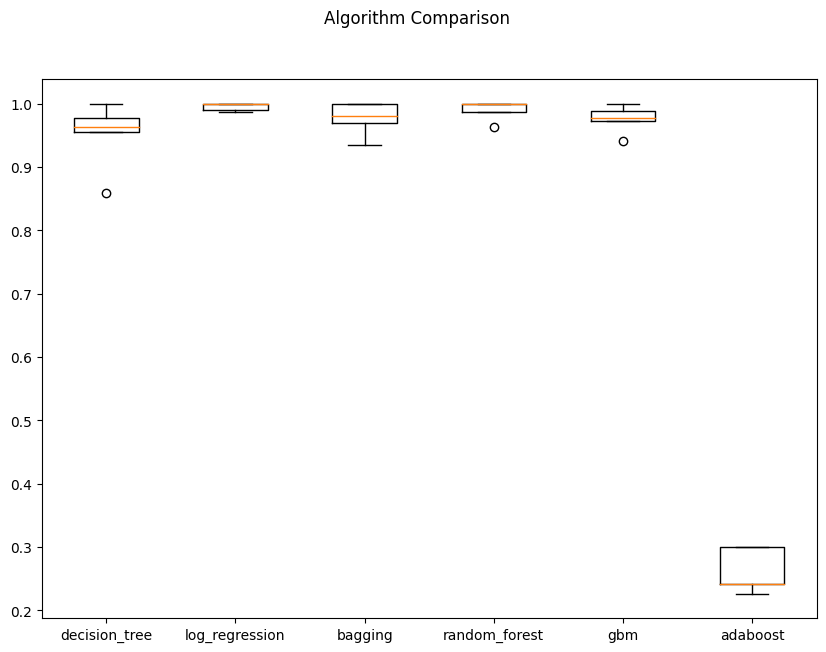

In [19]:
fig = plt.figure(figsize=(10,7))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(cv_results)
ax.set_xticklabels(model_names)

### b) Visualize the Confusion Matricies

In [25]:
def build_confusion_matrix(model, name, X_test, target):
    '''
    Build a confusion matrix to understand classifications
    '''

    # Build matrix
    y_pred = model.predict(X_test)
    cm     = confusion_matrix(y_pred, target)

    # Calculate confusion matrix values for 2x2
    false_pos = cm.sum(axis=0) - np.diag(cm)
    false_neg = cm.sum(axis=1) - np.diag(cm)
    true_pos  = np.diag(cm)
    true_neg  = cm.sum() - (false_pos + false_neg + true_pos)

    TPR = true_pos / (true_pos+false_neg) # Sensitivity / true positive rate
    TNR = true_neg / (true_neg+false_neg) # Specificity / true negative rate
    FPR = false_neg / (false_pos+true_neg) # Fall out / False positive rate
    FNR = false_neg / (true_pos+false_neg) # False negative rate

    total    = TPR.sum() + FNR.sum() + FPR.sum() + TNR.sum()
    percents = [round((TPR.sum()/total)*100, 2), round((FNR.sum()/total)*100, 2),
                round((FPR.sum()/total)*100, 2), round((TNR.sum()/total)*100, 2)]
    sums     = [round(TPR.sum(), 2), round(FNR.sum(), 2), 
                round(FPR.sum(), 2), round(TNR.sum(), 2)]
    labels   = np.asarray([f'{sums[0]}\n{percents[0]}%',
                f'{sums[1]}\n{percents[1]}%',
                f'{sums[2]}\n{percents[2]}%',
                f'{sums[3]}\n{percents[3]}%']).reshape(2,2)


    plt.figure(figsize=(6,4))
    sns.heatmap(np.asarray(sums).reshape(2,2), annot=labels, fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(name)
    plt.show()

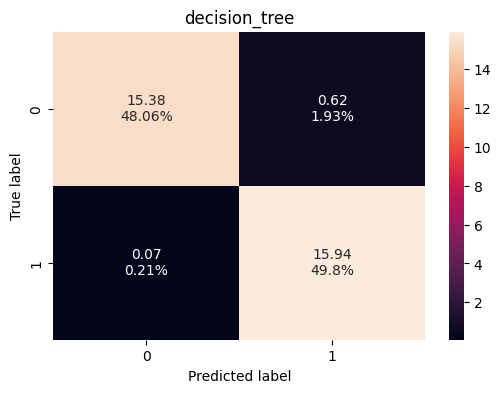

-------------------------


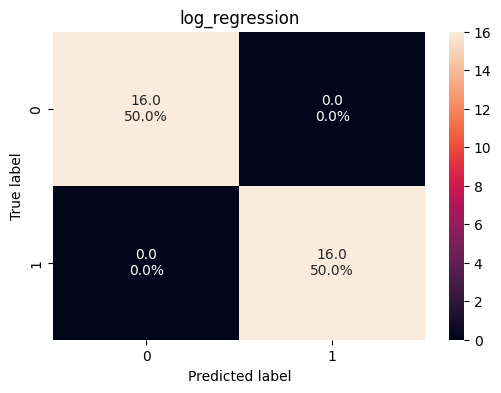

-------------------------


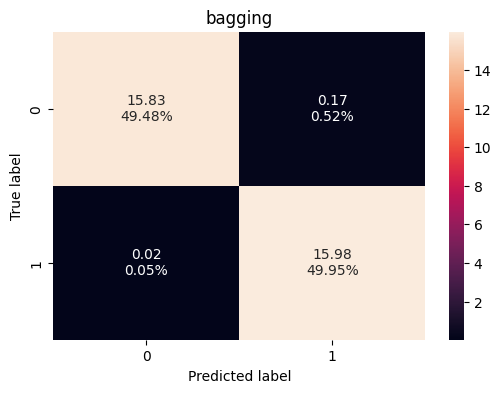

-------------------------


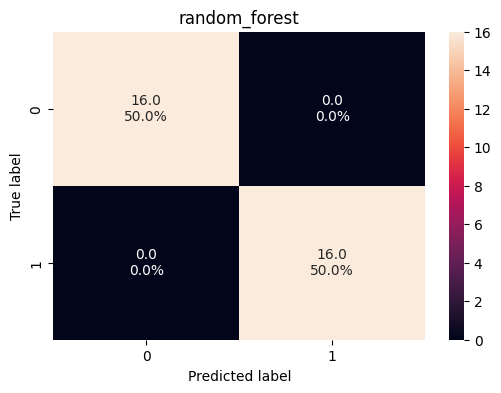

-------------------------


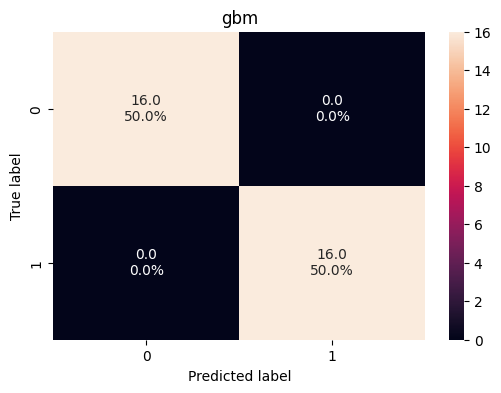

-------------------------


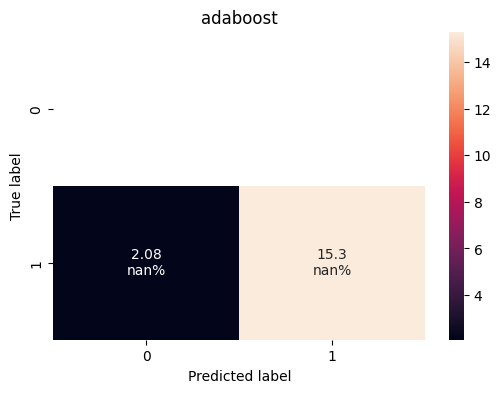

-------------------------


In [26]:
for name, model in models:
    build_confusion_matrix(model, name, X_test, y_test)
    print('-------------------------')

## Step 6 - Repeat with a new dataset